# Training Notebook Deep Q-Learning Project (MHBF)
Kevin Ferreira, kevin.ferreira@campus.tu-berlin.de   
Reihaneh Taghizadegan, reihaneh@bccn-berlin.de

In [147]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import required packages
import gym
import gym_grid
    
import matplotlib.pyplot as plt

import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython import display
from collections import namedtuple, deque
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
#Choose device to run the notebook
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

cpu


# 0. Environment Implementation

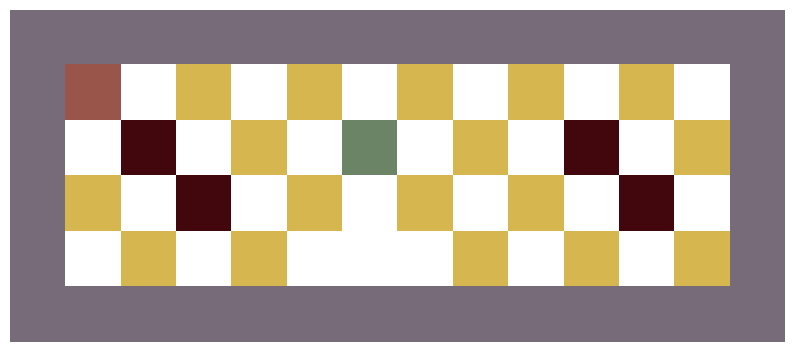

In [170]:
# Choose the environment 
env = gym.make("LinearTrack-v0")
env = gym.make("DeadlyGrid-v0")

# Visualize the environment
plt.figure(figsize=(10, 10))
_, obs_to_render = env.reset_with_render()
env.reset()
env.render(obs_to_render)

In [172]:
#Print useful data
print('State space: ', env.observation_space)
print('State shape: ', env.observation_space.shape)
print('Action space: ', env.action_space)
print('Number of actions: ', env.action_space.n)

State space:  Box(0, 1, (6, 14, 5), uint8)
State shape:  (6, 14, 5)
Action space:  Discrete(5)
Number of actions:  5


# 1. Definition of model and params

In [221]:
# Discount factor
GAMMA = 0.99
# Max iter per game
MAX_ITER = 50
# Number of step
N_STEP = 225000
# Number of game
N_GAME = int(N_STEP/MAX_ITER)

# Capacity of the replay buffer
BUFFER_SIZE = 1000
# Update target net every ... episodes
UPDATE_EVERY= int(500/MAX_ITER)

# Batch size
BATCH_SIZE = 128
# Learning rate
LEARNING_RATE = 0.001

# Eval Episode
EVAL_EPISODE = 10
# Number of eval
N_EVAL = 20
# Hidden Units
HIDDEN_UNITS = 256
# Hidden layers
HIDDEN_LAYERS = 1
# Initial value of epsilon
EPSILON_START = 1.0
# End value of epsilon
EPSILON_END = 0.01
# Epsilon decay
EPSILON_DECAY = (EPSILON_START - EPSILON_END) / N_STEP
# Initial value of epsilon
BETA_START = 0.4
# End value of epsilon
BETA_END = 1.0
# Epsilon decay
BETA_INC = (BETA_START - BETA_END) / N_STEP
ALPHA = 0.6
# SEED
SEED = 1
params = {'gamma': GAMMA, 'lr': LEARNING_RATE, 'bacth_size': BATCH_SIZE,
          'buffer_size': BUFFER_SIZE, 'update_step': UPDATE_EVERY,
          'hidden_unit': HIDDEN_UNITS, 'hidden_laye': HIDDEN_LAYERS,'n_game': N_GAME}

In [223]:
class DQN(nn.Module):
    """
    Class for the deep Q agent
    """
    def __init__(self, input_dim, output_dim, hidden_units, hidden_layers):
        super(DQN, self).__init__()

        self.action_space_size = output_dim
        self.hidden_layers = hidden_layers
        self.layer_in = nn.Linear(input_dim, hidden_units)
        self.hidden_layer= nn.Linear(hidden_units, hidden_units)
        self.layer_out = nn.Linear(hidden_units, output_dim)

    def forward(self, x):
        x = F.relu(self.layer_in(x.float()))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden_layer(x))
        x = self.layer_out(x)
        return x

    # E-greedy
    def action(self, state, epsilon):
        """
        Select an action according to the epsilon greedy policy
        """
        if random.random() > epsilon:
            q_value = self.forward(state)
            action  = int(torch.argmax(q_value, dim=-1))
        else:
            action = random.randrange(self.action_space_size)
        return action

    # soft max
    def action_sm(self, state, eps):
        """
        Select an action according to the soft-max policy
        """
        q_values = self.forward(state)
        probabilities = F.softmax(q_values / eps, dim=-1)
        action = torch.multinomial(probabilities, 1).item()
        return action

In [225]:
def test_agent(model):
    """
    Function to test the model
    Return the average returns of the testing episode 
    """
    done_test = False
    episode_return = 0
    i = 0
    state_test = torch.tensor(env.reset(), dtype=torch.float32).flatten().to(device)
    with torch.no_grad():
        while not done_test:
            action_test = model.action(state_test, 0)
            state_test, reward_test, done_test, info = env.step(action_test)
            state_test = torch.tensor(state_test, dtype=torch.float32).flatten().to(device)
            episode_return += GAMMA**i * reward_test
            i += 1
    return episode_return

In [227]:
def set_seed(seed):
    """
    Set all the seed to a specifiv value
    """
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

# 2. Baseline

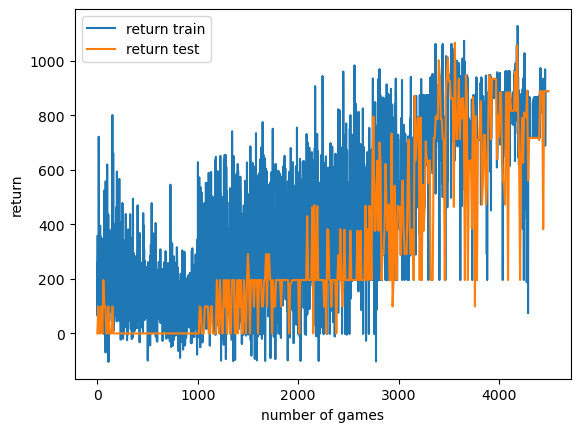

100%|██████████| 4500/4500 [17:16<00:00,  4.34it/s]


In [230]:
set_seed(SEED)
# Setting the model
model_baseline = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                     env.action_space.n,
                     HIDDEN_UNITS,
                     HIDDEN_LAYERS).to(device)

# Setting the optimizer
optimizer = optim.Adam(params=model_baseline.parameters(), lr=LEARNING_RATE)

# Setting the results dictionnary
results_baseline = {
    'params' : params,
    'weights': {},
    'step_game': [],
    'rewards_test': [],
    'rewards_train': [],
    'loss': []
}

eps = EPSILON_START
# TRAINING LOOP
for game in tqdm(range(N_GAME)):
    
    done = False
    state = torch.from_numpy(env.reset().flatten()).to(device)
    r_train = 0
    step = 0
    
    # GAME LOOP
    while not done:
        # Taking action
        action = model_baseline.action(state, eps)
        next_state, reward, done, info = env.step(action)
        next_state = torch.from_numpy(next_state.flatten()).to(device)
        r_train += GAMMA**step*reward

        # Network update
        next_state_values = model_baseline(next_state).max().detach()
        state_action_values = model_baseline(state)[action]
        expected_q_value = reward + GAMMA * next_state_values * (1 - done)
        loss = nn.MSELoss()(state_action_values, expected_q_value)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        state = next_state
        results_baseline['loss'].append(float(loss))
        step += 1
        eps -= EPSILON_DECAY
        #eps *= np.exp(-10e-3)
    
    results_baseline['step_game'].append(step)
    results_baseline['rewards_train'].append(r_train)
    
    # TESTING LOOP
    if game%EVAL_EPISODE == 0:
        r_test = []
        for j in range(N_EVAL):
            r = test_agent(model_baseline)
            r_test.append(r)

        results_baseline['weights'][game] = model_baseline.state_dict()
        results_baseline['rewards_test'].append(np.mean(r_test))

        # Plotting
        display.clear_output(True)        
        plt.plot(results_baseline['rewards_train'], label = "return train")
        plt.plot([EVAL_EPISODE * i for i in range(int(game/EVAL_EPISODE)+1)],
                 results_baseline['rewards_test'], label = "return test")
        plt.legend()
        plt.xlabel("number of games")
        plt.ylabel("return")
        plt.show()

# Saving results
torch.save(results_baseline, 'results_baseline.pth')


KeyboardInterrupt: 

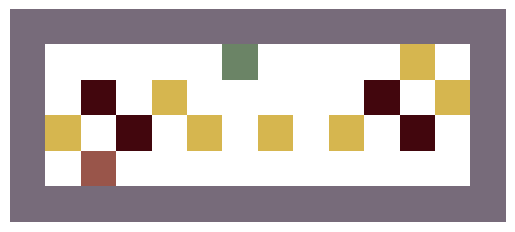

In [236]:
# Running one game
state, obs_to_render = env.reset_with_render()
state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_baseline.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)

# 3. Replay Buffer

In [301]:
class ReplayBuffer:
    def __init__(self, data_names, buffer_size, batch_size):
        self.data_keys = data_names
        self.data_dict = {}
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.reset()

    def reset(self):
        for name in self.data_keys:
            self.data_dict[name] = deque(maxlen=self.buffer_size)

    def push(self, data):
        """Add a transition to the buffer."""
        for key in self.data_keys:
            self.data_dict[key].append(data[key])

    def sample(self):
        """Sample a batch of transitions."""
        indices = random.sample(range(len(self)), self.batch_size)
        batch = [{key: self.data_dict[key][i] for key in self.data_keys} for i in indices]
        return batch

    def __len__(self):
        return len(next(iter(self.data_dict.values())))

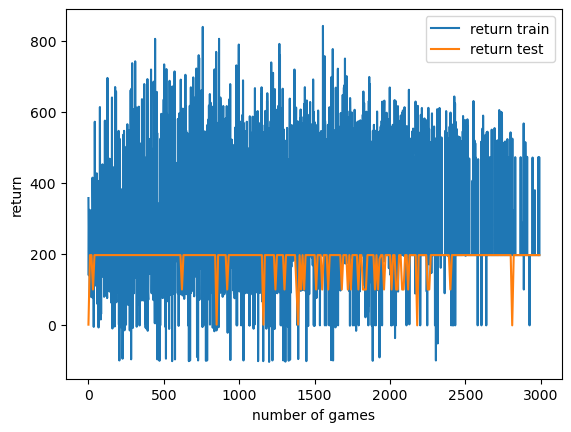

100%|██████████| 3000/3000 [08:05<00:00,  6.18it/s]


In [303]:
set_seed(SEED)
model_replay_buffer = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)
replay_buffer = ReplayBuffer(['state', 'action', 'reward', 'next_state', 'done'],
                             BUFFER_SIZE, BATCH_SIZE)

optimizer = optim.Adam(params=model_replay_buffer.parameters(), lr=LEARNING_RATE)

results_rb = {
    'params' : params,
    'weights': {},
    'step_game': [],
    'rewards_test': [],
    'rewards_train': [],
    'loss': []
}

eps = EPSILON_START
for game in tqdm(range(N_GAME)):
    
    done = False
    state = torch.from_numpy(env.reset().flatten()).to(device) 
    r_train = 0
    step = 0
    
    while not done:
        action = model_replay_buffer.action(state, eps)
        next_state, reward, done, info = env.step(action)
        next_state = torch.from_numpy(next_state.flatten()).to(device) 
        replay_buffer.push({'state':state, 'action':action, 'reward':reward,
                            'next_state':next_state, 'done':done})
        r_train += GAMMA**step*reward

        if len(replay_buffer) >= replay_buffer.batch_size:
            batch = replay_buffer.sample()
            states = torch.stack([b['state'] for b in batch]).to(device)
            actions = torch.tensor([b['action'] for b in batch]).to(device)
            rewards = torch.tensor([b['reward'] for b in batch]).to(device)
            next_states = torch.stack([b['next_state'] for b in batch]).to(device)
            dones = torch.tensor([b['done'] for b in batch], dtype=torch.float32).to(device)
            
            state_action_values = model_replay_buffer(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_states_values = model_replay_buffer(next_states).max(1)[0].detach()
            expected_q_values = rewards + GAMMA * next_states_values * (1 - dones)
            loss = nn.MSELoss()(state_action_values, expected_q_values)
            results_rb['loss'].append(float(loss))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        step += 1
        eps -= EPSILON_DECAY

    results_rb['rewards_train'].append(r_train)
    results_rb['step_game'].append(step)

    if game%EVAL_EPISODE == 0:
        r_test = []
        for j in range(10):
            r = test_agent(model_replay_buffer)
            r_test.append(r)
        results_rb['weights'][game] = model_replay_buffer.state_dict()
        results_rb['rewards_test'].append(np.mean(r_test))

        display.clear_output(True)
        plt.plot(results_rb['rewards_train'], label = "return train")
        plt.plot([EVAL_EPISODE * i for i in range(int(game/EVAL_EPISODE)+1)],
                 results_rb['rewards_test'], label = "return test")
        plt.legend()
        plt.xlabel("number of games")
        plt.ylabel("return")
        plt.show()
torch.save(results_rb, 'results_rb.pth')

700


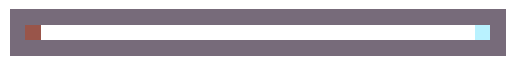

In [63]:
state, obs_to_render = env.reset_with_render()
state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_replay_buffer.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)

# 4. Target Network

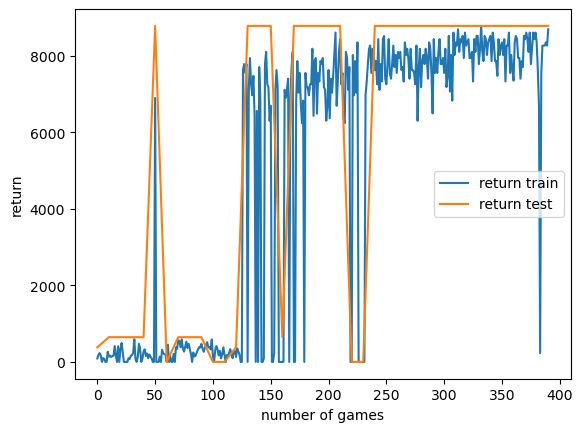

100%|██████████| 400/400 [00:33<00:00, 12.04it/s]


In [194]:
set_seed(SEED)
model_tn = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

model_tn_target = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)

model_tn_target.load_state_dict(model_tn.state_dict())


optimizer = optim.Adam(params=model_tn.parameters(), lr=LEARNING_RATE)

results_tn = {
    'params' : params,
    'weights': {},
    'step_game': [],
    'rewards_test': [],
    'rewards_train': [],
    'loss': []
}

eps = EPSILON_START

for game in tqdm(range(N_GAME)):
    
    done = False
    state = torch.from_numpy(env.reset().flatten()).to(device)
    r_train = 0
    step = 0
    
    while not done:
        action = model_tn.action(state, eps)
        next_state, reward, done, info = env.step(action)
        next_state = torch.from_numpy(next_state.flatten()).to(device)
        r_train += GAMMA**step*reward
        
        next_state_values = model_tn_target(next_state).max().detach()
        state_action_values = model_tn(state)[action]

        expected_q_value = reward + GAMMA * next_state_values * (1 - done)
        loss = nn.MSELoss()(state_action_values, expected_q_value)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        state = next_state
        results_tn['loss'].append(float(loss))
        step += 1
        eps -= EPSILON_DECAY
       
    results_tn['step_game'].append(step)
    results_tn['rewards_train'].append(r_train)

    if game % UPDATE_EVERY == 0:
        model_tn_target.load_state_dict(model_tn.state_dict())

    if game % EVAL_EPISODE == 0:
        r_test = []
        for j in range(N_EVAL):
            r = test_agent(model_tn)
            r_test.append(r)
        
        results_tn['weights'][step] = model_tn.state_dict()
        results_tn['rewards_test'].append(np.mean(r_test))

        display.clear_output(True)
        plt.plot(results_tn['rewards_train'], label = "return train")
        plt.plot([EVAL_EPISODE * i for i in range(int(game/EVAL_EPISODE)+1)],
                 results_tn['rewards_test'], label = "return test")
        plt.legend()
        plt.xlabel("number of games")
        plt.ylabel("return")
        plt.show()

torch.save(results_tn, 'results_tn.pth')


10000


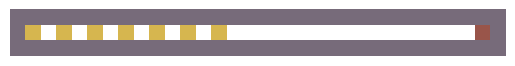

In [183]:
state, obs_to_render = env.reset_with_render()
state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_tn.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)

# 5. Loss Function Comparaison

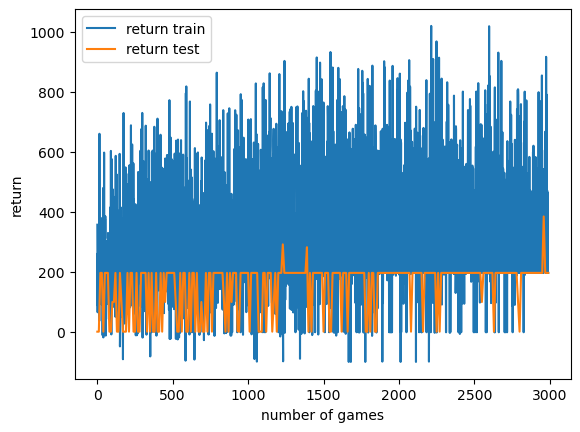

100%|██████████| 3000/3000 [05:58<00:00,  8.36it/s]


In [190]:
set_seed(SEED)

model_lf = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                     env.action_space.n,
                     HIDDEN_UNITS,
                     HIDDEN_LAYERS).to(device)

optimizer = optim.Adam(params=model_lf.parameters(), lr=LEARNING_RATE)

results_lf = {
    'params' : params,
    'weights': {},
    'step_game': [],
    'rewards_test': [],
    'rewards_train': [],
    'loss': []
}

eps = EPSILON_START

for game in tqdm(range(N_GAME)):
    
    done = False
    state = torch.from_numpy(env.reset().flatten()).to(device)
    r_train = 0
    step = 0
    
    while not done:
        
        action = model_lf.action(state, eps)
        next_state, reward, done, info = env.step(action)
        next_state = torch.from_numpy(next_state.flatten()).to(device)
        r_train += GAMMA**step*reward

        next_state_values = model_lf(next_state).max().detach()
        state_action_values = model_lf(state)[action]

        expected_q_value = reward + GAMMA * next_state_values * (1 - done)
        loss = nn.SmoothL1Loss()(state_action_values, expected_q_value)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        state = next_state
        results_lf['loss'].append(float(loss))
        step += 1
        eps -= EPSILON_DECAY
    
    results_lf['step_game'].append(step)
    results_lf['rewards_train'].append(r_train)
    
    if game%EVAL_EPISODE == 0:
        r_test = []
        for j in range(N_EVAL):
            r = test_agent(model_lf)
            r_test.append(r)

        results_lf['weights'][game] = model_lf.state_dict()
        results_lf['rewards_test'].append(np.mean(r_test))

        display.clear_output(True)
        
        plt.plot(results_lf['rewards_train'], label = "return train")
        plt.plot([EVAL_EPISODE * i for i in range(int(game/EVAL_EPISODE)+1)],
                 results_lf['rewards_test'], label = "return test")
        plt.legend()
        plt.xlabel("number of games")
        plt.ylabel("return")
        plt.show()
    
torch.save(results_lf, 'results_lf.pth')


In [ ]:
state, obs_to_render = env.reset_with_render()
state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_lf.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)

# 6. Prioritized Experience Replay

In [304]:
class PrioritizedReplayBuffer:
    def __init__(self, data_names, buffer_size, batch_size):
        self.data_keys = data_names
        self.data_dict = {}
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.priorities = deque(maxlen=self.buffer_size)
        self.reset()

    def reset(self):
        for name in self.data_keys:
            self.data_dict[name] = deque(maxlen=self.buffer_size)

    def push(self, data):
        """Add a transition to the buffer."""
        max_p = np.max(self.priorities) if len(self.data_dict)==0 else 1.0
        for key in self.data_keys:
            self.data_dict[key].append(data[key])
        self.priorities.append(max_p)

    def sample(self, beta):
        """Sample a batch of transitions."""
        probs = np.array(self.priorities) ** ALPHA
        probs /= np.sum(probs)
        indices =  np.random.choice(len(self), self.batch_size, p=probs)
        
        batch = [{key: self.data_dict[key][i] for key in self.data_keys} for i in indices]
        
        weights = (self.buffer_size * probs[indices]) ** (-beta)
        weights /= np.max(weights)
        return indices, batch, weights
        
    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = (np.abs(td_error) + 1e-10)
            
    def __len__(self):
        return len(next(iter(self.data_dict.values())))

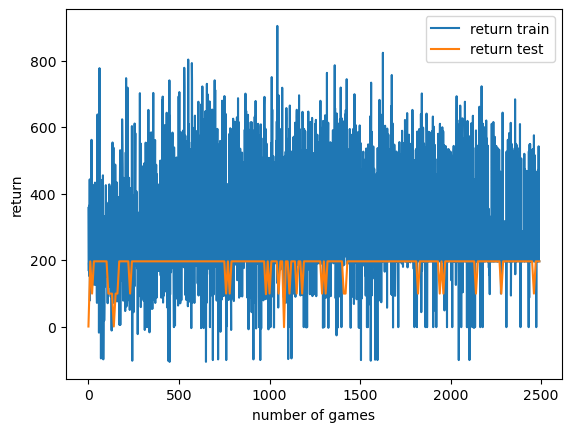

 83%|████████▎ | 2491/3000 [08:19<00:43, 11.66it/s]

In [ ]:
set_seed(SEED)
model_prb = DQN(env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2],
                          env.action_space.n,
                          HIDDEN_UNITS,
                          HIDDEN_LAYERS).to(device)
prb = PrioritizedReplayBuffer(['state', 'action', 'reward', 'next_state', 'done'],
                             BUFFER_SIZE, BATCH_SIZE)

optimizer = optim.Adam(params=model_prb.parameters(), lr=LEARNING_RATE)

results_prb = {
    'params' : params,
    'weights': {},
    'step_game': [],
    'rewards_test': [],
    'rewards_train': [],
    'loss': []
}

eps = EPSILON_START
beta = BETA_START
for game in tqdm(range(N_GAME)):
    
    done = False
    state = torch.from_numpy(env.reset().flatten()).to(device) 
    r_train = 0
    step = 0
    
    while not done:
        action = model_prb.action(state, eps)
        next_state, reward, done, info = env.step(action)
        next_state = torch.from_numpy(next_state.flatten()).to(device) 
        prb.push({'state':state, 'action':action, 'reward':reward,
                  'next_state':next_state, 'done':done})
        r_train += GAMMA**step*reward

        if len(prb) >= prb.batch_size:
            indices, batch, weights = prb.sample(beta)
            
            states = torch.stack([b['state'] for b in batch]).to(device)
            actions = torch.tensor([b['action'] for b in batch]).to(device)
            rewards = torch.tensor([b['reward'] for b in batch]).to(device)
            next_states = torch.stack([b['next_state'] for b in batch]).to(device)
            dones = torch.tensor([b['done'] for b in batch], dtype=torch.float32).to(device)
            
            state_action_values = model_prb(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_states_values = model_prb(next_states).max(1)[0].detach()
            expected_q_values = rewards + GAMMA * next_states_values * (1 - dones)
            
            td_errors = (state_action_values - expected_q_values)
            loss = torch.mean((td_errors)**2)
            results_prb['loss'].append(float(loss))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            prb.update_priorities(indices, td_errors.detach().numpy())
            
        step += 1
        eps -= EPSILON_DECAY
        beta += BETA_INC

    results_prb['rewards_train'].append(r_train)
    results_prb['step_game'].append(step)

    if game%EVAL_EPISODE == 0:
        r_test = []
        for j in range(10):
            r = test_agent(model_prb)
            r_test.append(r)
        results_prb['weights'][game] = model_prb.state_dict()
        results_prb['rewards_test'].append(np.mean(r_test))

        display.clear_output(True)
        plt.plot(results_prb['rewards_train'], label = "return train")
        plt.plot([EVAL_EPISODE * i for i in range(int(game/EVAL_EPISODE)+1)],
                 results_prb['rewards_test'], label = "return test")
        plt.legend()
        plt.xlabel("number of games")
        plt.ylabel("return")
        plt.show()
torch.save(results_prb, 'results_prb.pth')


200


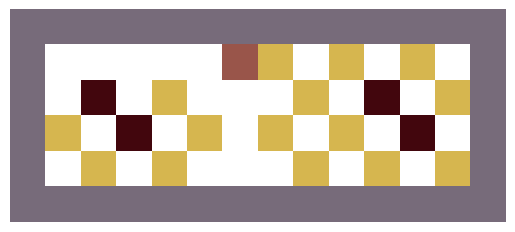

In [261]:
state, obs_to_render = env.reset_with_render()
state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
env.render(obs_to_render)
done = False
tot_rew_test = 0
with torch.no_grad():
        while not done:
            action = model_prb.action(state, 0)
            state, rew , done, _, obs_to_render = env.step_with_render(action)
            state = torch.tensor(state, dtype=torch.float32).flatten().to(device)
            tot_rew_test += rew
            env.render(obs_to_render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
print(tot_rew_test)